# A simple toy example for robustness curve separation

In [ ]:
import os
os.chdir("../")
import sys
import json
import math
import numpy as np
import numpy.matlib
import sklearn.svm
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set(context='paper')

## Plot settings:

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=True)

# dictionary that maps color string to 'good looking' seaborn colors that are easily distinguishable
colors = {
    "orange": sns.xkcd_rgb["yellowish orange"],
    "red": sns.xkcd_rgb["pale red"],
    "green": sns.xkcd_rgb["medium green"],
    "blue": sns.xkcd_rgb["denim blue"],
    "yellow": sns.xkcd_rgb["amber"],
    "purple": sns.xkcd_rgb["dusty purple"],
    "cyan": sns.xkcd_rgb["cyan"]
}

## Calculate and plot:

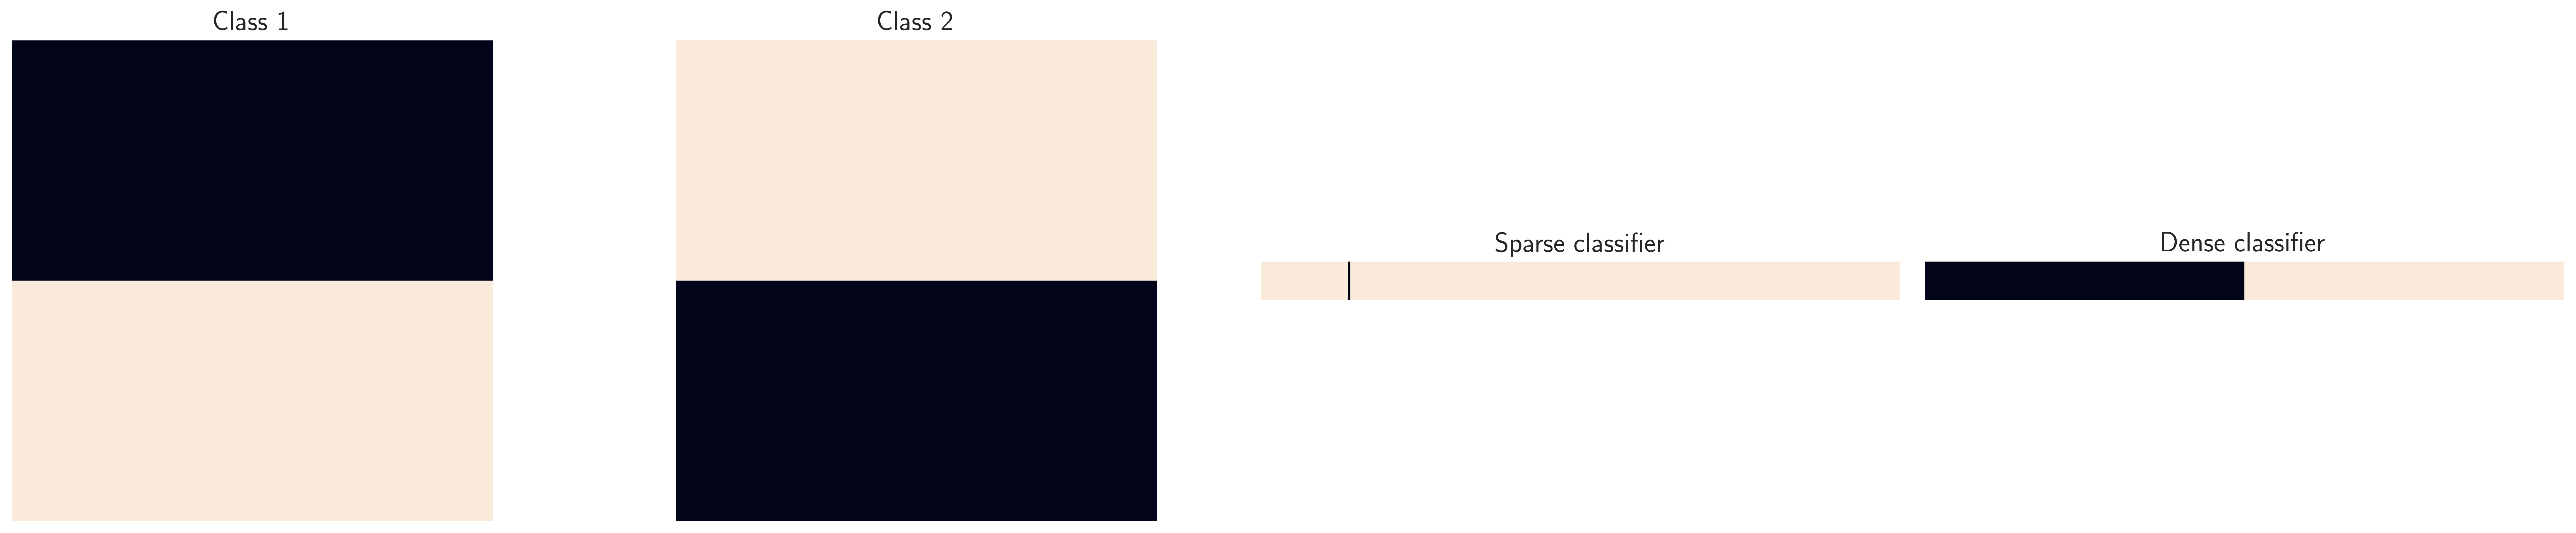

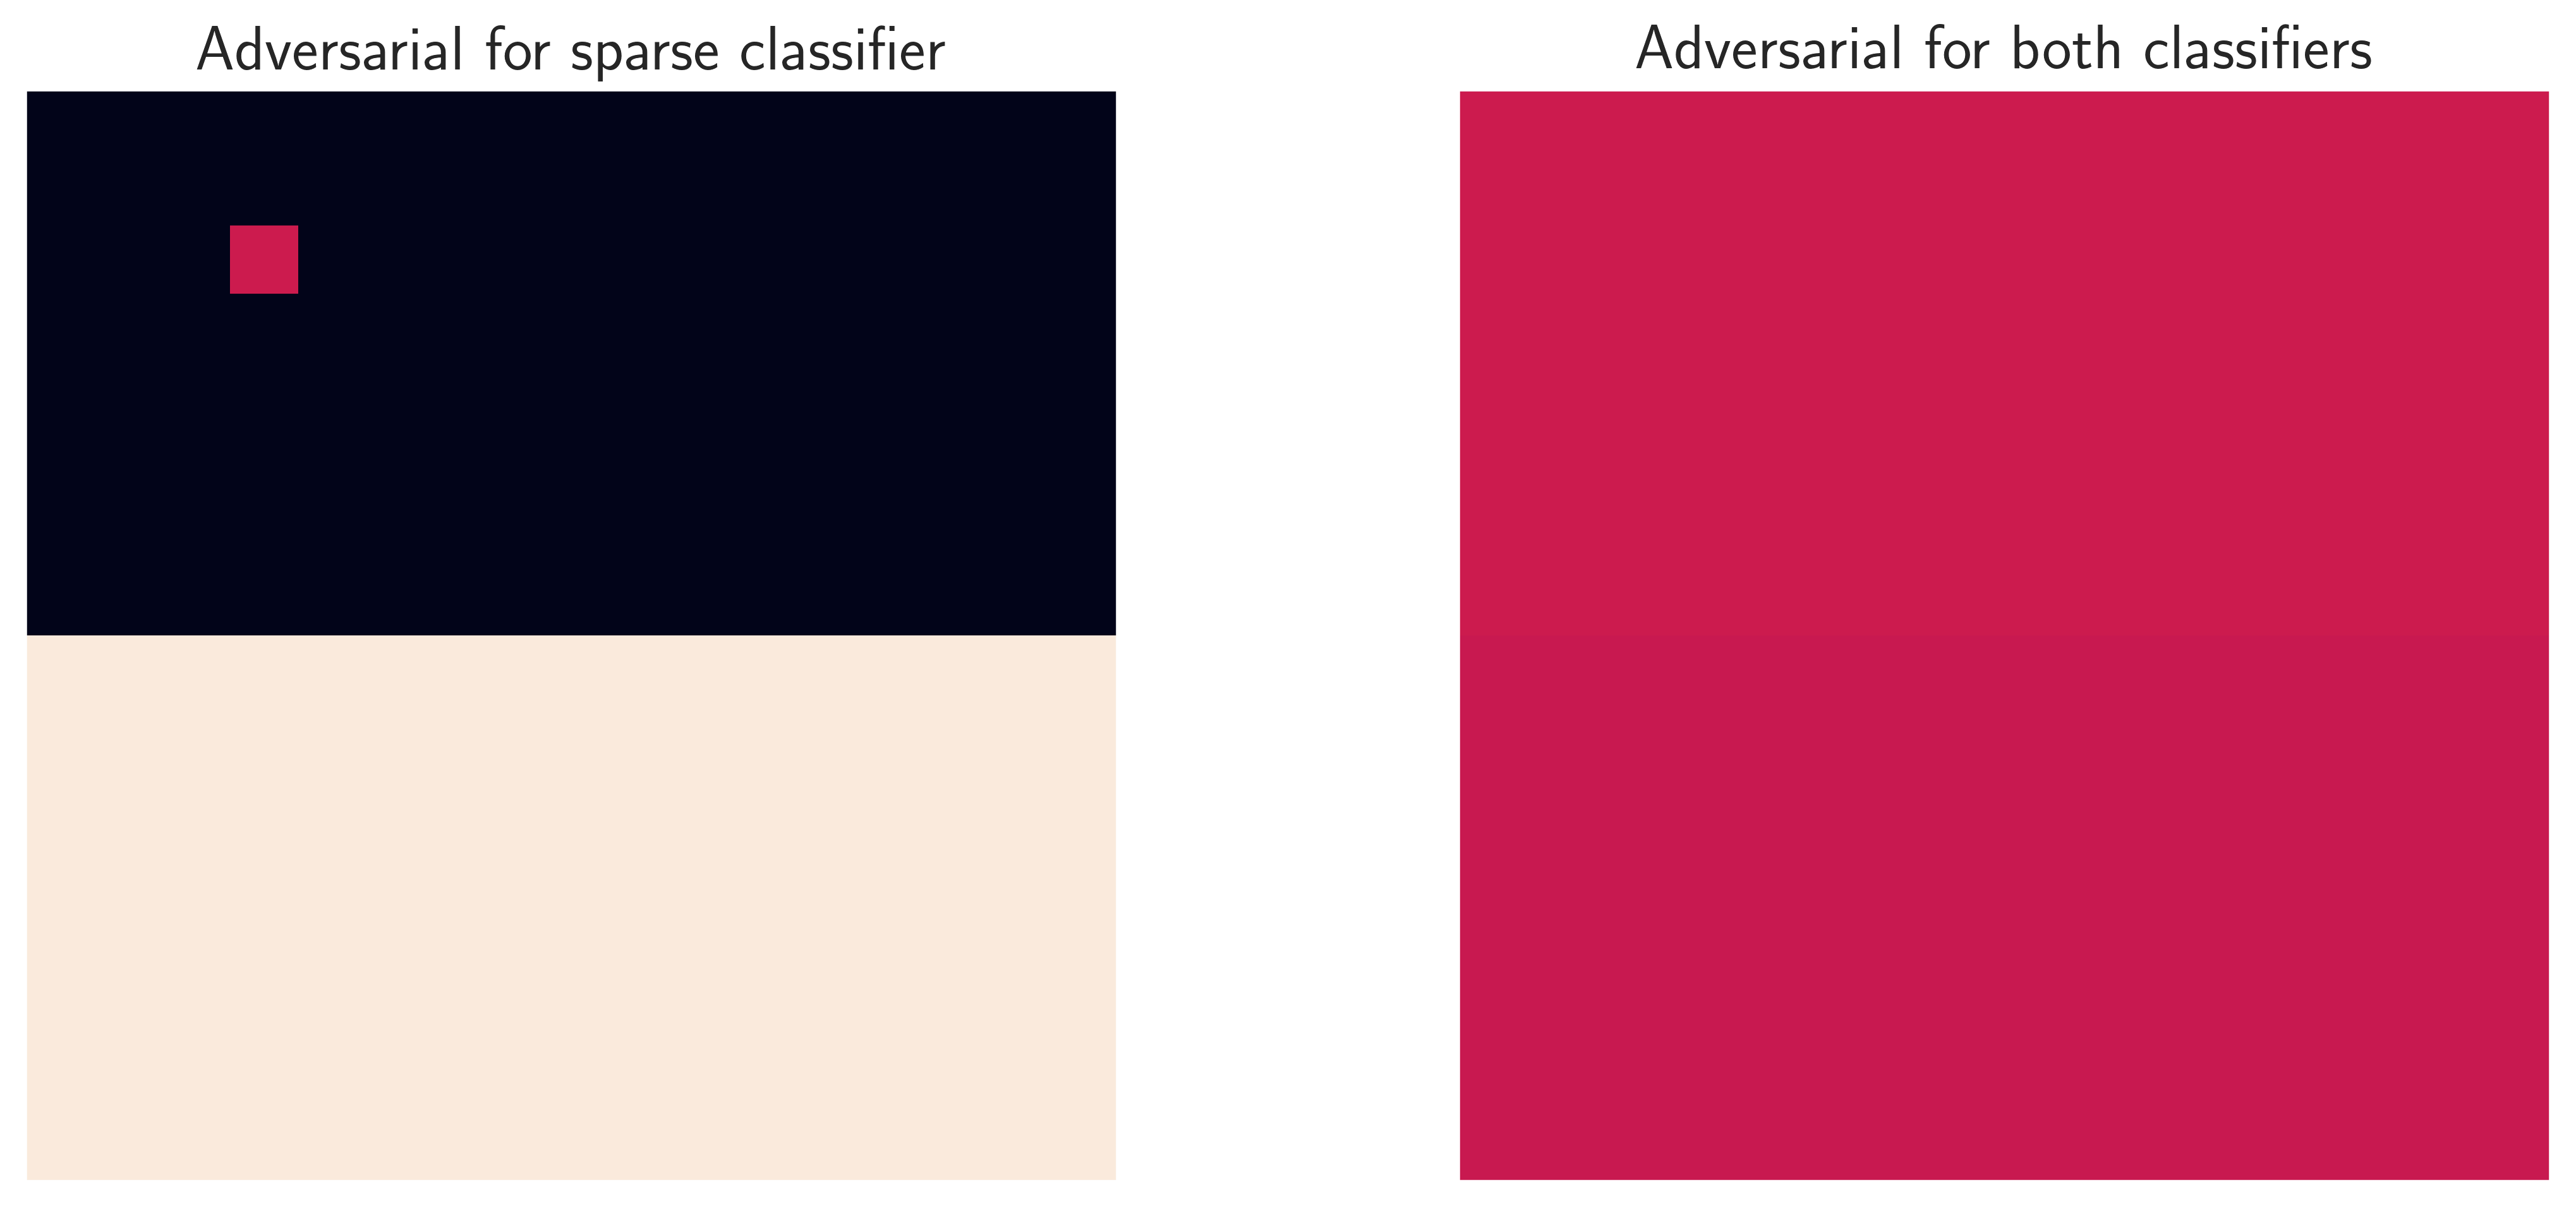

In [4]:
save_name_clf = "fig_toy_curve_separation_clf"
save_name_adv = "fig_toy_curve_separation_adv"
random_state = np.random.RandomState(42)

dim = 16
n_per_class = 100
data = np.ones((2 * n_per_class, dim**2))

vmin = -1
vmax = 1

data *= vmax
data[:n_per_class, :int(dim**2 / 2)] = vmin
data[n_per_class:, int(dim**2 / 2):] = vmin
labels = np.zeros(2 * n_per_class)
labels[:n_per_class] = 1

s1 = data[0, :]
s2 = data[n_per_class, :]

clf_l2 = sklearn.svm.LinearSVC(random_state=0, tol=1e-5)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clf_l2.fit(data, labels)
# print(clf_l2.coef_)

clf_l1 = sklearn.svm.LinearSVC(random_state=0,
                               tol=1e-5,
                               penalty="l1",
                               dual=False)
clf_l1.fit(data, labels)
# print(clf_l1.coef_)

wl1 = clf_l1.coef_.flatten()
wl2 = clf_l2.coef_.flatten()

shift = 1.01
# Adversarial for l_1 and l_2
adv1 = s1.copy()
adv1[:int(dim**2 / 2)] += shift
adv1[int(dim**2 / 2):] -= shift

# Adversarial for l_1 but not l_2
adv2 = s1.copy()
# i1 = np.argmax(wl1)
i2 = np.argmin(wl1)
# adv2[i1] -= shift
adv2[i2] += shift

cor = clf_l1.predict(s1.reshape(1, dim**2))
p1a1 = clf_l1.predict(adv1.reshape(1, dim**2))
p1a2 = clf_l1.predict(adv2.reshape(1, dim**2))
p2a1 = clf_l2.predict(adv1.reshape(1, dim**2))
p2a2 = clf_l2.predict(adv2.reshape(1, dim**2))

if p1a1 == cor:
    raise Exception("Adv1 is not an adversarial for l1.")
if p2a1 == cor:
    raise Exception("Adv1 is not an adversarial for l2.")

if p1a2 == cor:
    raise Exception("Adv2 is not an adversarial for l1.")
if p2a2 != cor:
    raise Exception("Adv2 is an adversarial for l2.")

repl1 = np.matlib.repmat(clf_l1.coef_, 16, 1)
repl2 = np.matlib.repmat(clf_l2.coef_, 16, 1)

vmin = min(
    (min(s1), min(s2), min(min(clf_l1.coef_)), min(min(clf_l2.coef_)),
     min(adv1), min(adv2)))
vmax = max(
    (max(s1), max(s2), max(max(clf_l1.coef_)), max(max(clf_l2.coef_)),
     max(adv1), max(adv2)))

n_cols = 4
n_rows = 1

fig, axx = plt.subplots(n_rows,
                        n_cols,
                        figsize=(6 * n_cols, 5 * n_rows),
                        dpi=400)

axx[0].imshow(s1.reshape(dim, dim), vmin=vmin, vmax=vmax)
axx[1].imshow(s2.reshape(dim, dim), vmin=vmin, vmax=vmax)
for ax in axx:
    ax.tick_params(
        axis="both",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        left=False,  # ticks along the top edge are off
        right=False,  # ticks along the top edge are off
        labelbottom=False,
        labelleft=False,
    )
    ax.grid(False)

axx[0].set_title('Class 1')
axx[1].set_title('Class 2')

# fig, axx = plt.subplots(n_rows, n_cols)

axx[2].imshow(repl1)
axx[3].imshow(repl2)
for ax in axx:
    ax.tick_params(
        axis="both",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        left=False,  # ticks along the top edge are off
        right=False,  # ticks along the top edge are off
        labelbottom=False,
        labelleft=False,
    )
    ax.grid(False)
axx[2].set_title('Sparse classifier')
axx[3].set_title('Dense classifier')

fig.tight_layout()
fig.savefig('res/{}.pdf'.format(save_name_clf))

n_rows = 1
n_cols = 2

fig, axx = plt.subplots(n_rows,
                        n_cols,
                        figsize=(6 * n_cols, 5 * n_rows),
                        dpi=400)

axx[1].imshow(adv1.reshape(dim, dim), vmin=vmin, vmax=vmax)
axx[0].imshow(adv2.reshape(dim, dim), vmin=vmin, vmax=vmax)
for ax in axx:
    ax.tick_params(
        axis="both",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        left=False,  # ticks along the top edge are off
        right=False,  # ticks along the top edge are off
        labelbottom=False,
        labelleft=False,
    )
    ax.grid(False)

axx[1].set_title('Adversarial for both classifiers')
axx[0].set_title('Adversarial for sparse classifier')

fig.tight_layout()
fig.savefig('res/{}.pdf'.format(save_name_adv))